## Analyze A/B Test Results for an E-Commerce Website

This project aims to demonstrate the topics covered in the statistics course of Udacity's Data Analysis Nanodegree.

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. 

A/B tests are used to test changes on a web page by running an experiment where a control group sees the old version, while the experiment group (treatment group is this case) sees the new version. A metric is then chosen to measure the level of engagement from users in each group. The results from this test are then used to determine whether one version is more effective than the other. A/B testing is similar to hypothesis testing with the following hypotheses:

* Null Hypothesis: The new version is not better, or even worse, than the old version
* Alternative Hypothesis: The new version is better than the old version


For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, I will import the libraries that will be used for this project.

In [36]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#I am setting the seed to assure that my results are reproduceable
random.seed(42)

Next I will read in the `ab_data.csv` data and store it in `df`.  


In [37]:
df = pd.read_csv('ab_data.csv')

In [38]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


I'll find the number of rows in the dataset.

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [40]:
len(df)

294478

Next I'll check the number of unique users in the dataset.

In [41]:
df['user_id'].nunique()

290584

The proportion of users converted can be found as follows:

In [42]:
percent_unique_convert=df.query('converted=="1"').user_id.nunique()/df["user_id"].nunique()*100

In [43]:
percent_unique_convert

12.104245244060237

In [44]:
percent_unique_convert1 = df[df['converted']==1]['user_id'].nunique()/df['user_id'].nunique()*100
percent_unique_convert1

12.104245244060237

I will check the number of times the `new_page` and `treatment group` don't line up.

In [45]:
first_comb = df[(df['group']=='treatment') & (df['landing_page']!='new_page')]

In [46]:
first_comb.head(5)

,user_id,timestamp,group,landing_page,converted
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
685,666385,2017-01-23 08:11:54.823806,treatment,old_page,0
713,748761,2017-01-10 15:47:44.445196,treatment,old_page,0


In [47]:
second_comb = df[(df['group']!='treatment') & (df['landing_page']=='new_page')]

In [48]:
second_comb.head(5)

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
490,808613,2017-01-10 21:44:01.292755,control,new_page,0
846,637639,2017-01-11 23:09:52.682329,control,new_page,1
850,793580,2017-01-08 03:25:33.723712,control,new_page,1


In [49]:
no_line_up = first_comb.count() + second_comb.count()
no_line_up

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

There are 3893 instances where new page and treatment group do not line up.

The information below shows there are no rows with missing values.

In [50]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if these rows truly received the new or old page. It is possible that errors were introduced when capturing these data points. I will therefore therefore create a new dataframe not containing these data points.


In [51]:
df2a = df[((df['group']=='treatment') & (df['landing_page']=='new_page'))]

In [52]:
df2b = df[((df['group']=='control') & (df['landing_page']=='old_page'))]

In [53]:
df2 = pd.concat([df2a, df2b], axis=0)

In [54]:
df2.head(5)

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [55]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

First I will determine how many unique **user_id**s are in **df2**?

In [56]:
df2['user_id'].nunique()

290584

There is one **user_id** repeated in **df2**.

In [57]:
dupli = df2[df2['user_id'].duplicated()==True]


In [58]:
dupli.index[0]

2893

Below you can see the row information for the repeat **user_id**? 

In [59]:
dupli

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


I will remove one of the rows with a duplicate **user_id**, keeping my dataframe as **df2**.

In [60]:
df2=df2.drop(df2.index[2893])

In [61]:
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [62]:
df2.reset_index(inplace=True);

In [63]:
df2.head(5)

,index,user_id,timestamp,group,landing_page,converted
0,2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
1,3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
2,6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
3,8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
4,9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


What is the probability of an individual converting regardless of the page they receive? 

In [64]:
convert=df2.query('converted=="1"').user_id.nunique()/df["user_id"].nunique()
convert

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [65]:
control = df2[df2['group']=="control"]

In [66]:
control_convert = (control[control['converted']==1].user_id.nunique())/(control['user_id'].nunique())
control_convert

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [67]:
treatment = df2[df2['group']=='treatment']
treatment.head(5)

,index,user_id,timestamp,group,landing_page,converted
0,2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
1,3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
2,6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
3,8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
4,9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [68]:
treatment_convert = treatment[treatment['converted']==1].user_id.nunique()/treatment['user_id'].nunique()
treatment_convert

0.11880888313869065

What is the probability that an individual received the new page?

In [69]:
len(df2[df2['landing_page']=='new_page'].user_id.unique())/len(df2['user_id'].unique())

0.5000602237570677

At this point, is sufficient evidence to say that the new treatment page leads to more conversions?

From the calculations performed above, the percentage conversion rate is greater for the control group & old-page, at 12.04%, than for the treatment group & new page which has a conversion of 11.88%. This seems to indicate that the old page is a better option, since it gave a higher conversion rate. <br/>

The fact that the data is split approximately 50/50 between control and treatment group increases the reliability of the conclusions drawn when comparing these two groups. If there were many more instances of one page than the other in the dataset, this may have changed the results in favour of one of the pages. Furthermore, the large dataset that is being worked with also increases the reliability of the results obtained when performing calculations on this data. 

The difference between these conversion rates is quite small, at 0.16%, so before saying one page is better than the other it is necessary to first see if this difference is significant and not just due to chance. I will investigate this by bootstrapping the data sample and simulating a sample distribution for the difference in proportions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, I will need to make the decision just based on all the data provided. I will assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. My null and alternative hypotheses will be:

**$H_{0}$** :  **$p_{new}$** - **$p_{old}$** <= 0 </br>

**$H_{1}$** :   **$p_{new}$** - **$p_{old}$** > 0


I will assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, I will assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

I will use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

I will perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

The cells below provide the necessary parts of this simulation. 

What is the **convert rate** for $p_{new}$ under the null? 

In [70]:
convert=df2.query('converted=="1"').user_id.nunique()/df["user_id"].nunique()
convert

0.11959708724499628

What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [71]:
convert=df2.query('converted=="1"').user_id.nunique()/df["user_id"].nunique()
convert

0.11959708724499628

What is $n_{new}$?

In [72]:
new = df2[df2['landing_page']=='new_page']
len(new)

145310

What is $n_{old}$?

In [73]:
old = df2[df2['landing_page']=='old_page']
len(old)

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [74]:
new_page_converted = np.random.choice([1,0],size = len(new),p = [convert,1-convert])

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [75]:
old_page_converted = np.random.choice([1,0],size = len(old),p = [convert,1-convert])

Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [76]:
(new_page_converted.mean() - old_page_converted.mean())

0.00030772251697086528

Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [79]:
p_diffs=[]
for i in range(10000):
    new_page_convert = np.random.choice([1, 0], size=len(new), p=[convert, (1-convert)])
    old_page_convert = np.random.choice([1, 0], size=len(old), p=[convert, (1-convert)])
    p_diff = new_page_convert.mean()-old_page_convert.mean()
    p_diffs.append(p_diff)

Plot a histogram of the **p_diffs**. 

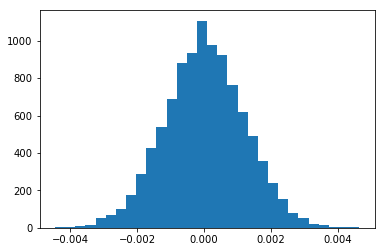

In [80]:
plt.hist(p_diffs,bins=30);

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

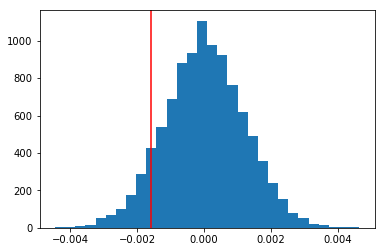

In [81]:
plt.hist(p_diffs,bins=30)
plt.axvline(x=(treatment_convert-control_convert),color="r");

In [82]:
diff_ab_data = (treatment_convert-control_convert)

In [83]:
(np.array(p_diffs)>diff_ab_data).mean()

0.90669999999999995

The p-value calculated above, is very high showing that there is evidence that we should not reject the null hypothesis. The p-value was calculated by finding the proportion of values in the null distribution that is greater than the observed difference in the original sample. 


I could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Next I will calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [84]:
convert_old = control[control['converted']==1].user_id.nunique()
convert_new = treatment[treatment['converted']==1].user_id.nunique()
n_old = treatment['user_id'].nunique()
n_new = control['user_id'].nunique()

In [85]:
n_new

145274

In [86]:
n_old

145309

In [87]:
new = df2[df2['landing_page']=='new_page']

In [88]:
old = df2[df2['landing_page']=='old_page']

In [89]:
len(old[old['converted']==1])

17489

In [90]:
len(new[new['converted']==1])

17264

In [91]:
import statsmodels.api as sm

convert_old = 17489 
convert_new = 17264 
n_old = 145274 
n_new = 145310

/Users/elzaniviljoen/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Now I will use `stats.proportions_ztest` to compute my test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [92]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])
print("z_score:",z_score,"p_value:", p_value)

z_score: 1.31092419842 p_value: 0.189883374482


In [93]:
from scipy.stats import norm

norm.cdf(z_score)

0.90505831275902449

The above cell tells us how significant our z-score is. Next we can calculate what critical value at 95% confidence is.

In [94]:
norm.ppf(1-(0.05/2))

1.959963984540054

The p-value is significant, suggesting that we cannot reject the null hypothesis. 
It is clear that the calculated z is less than the critical value, for a 95% confidence level. Hence, assuming a 95% confidence level, this also shows that we cannot reject the null hypothesis. The difference between the p calculated here and the p calculated in part j could be due to assumptions used in the built-in z-test technique.

<a id='regression'></a>
### Part III - A regression approach

In this final part, I will show that the result I acheived in the previous A/B test can also be acheived by performing regression.<br><br>

Since each row is either a conversion or no conversion, one would have to use logistic regression in this case.

The goal is to use **statsmodels** to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives.  However, I first need to create a column for the intercept, and create a dummy variable column for which page each user received.  </br>

I'll add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [95]:
import statsmodels.api as sm

In [96]:
df2.head(3)


,index,user_id,timestamp,group,landing_page,converted
0,2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
1,3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
2,6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1


In [97]:
df3=df2.copy()

In [98]:
df3['intercept']=1

In [99]:
df3.head(5)

,index,user_id,timestamp,group,landing_page,converted,intercept
0,2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
1,3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
2,6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1
3,8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1
4,9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1


In [100]:
df3[['other','ab_page']]= pd.get_dummies(df3['group'])

In [101]:
df3.head(3)

,index,user_id,timestamp,group,landing_page,converted,intercept,other,ab_page
0,2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
1,3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
2,6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1


In [102]:
df3.drop('other',axis=1,inplace=True)

In [103]:
df3.head(3)

,index,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
1,3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
2,6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1


I am going to use **statsmodels** to import my regression model.  Then I will instantiate the model, and fit the model using the two new columns I created above, to predict whether or not an individual converts.

In [104]:
logit_mod=sm.Logit(df3['converted'],df3[['intercept','ab_page']])

In [105]:
results=logit_mod.fit();

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Below is the summary of my model below.

In [106]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 03 May 2018   Pseudo R-squ.:               8.077e-06
Time:                        12:38:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value obtained here is 0.190, which is large enough to indicated that we must not reject the NULL hypotheis. It is similar to the p-value obtained by the propotions_ztest from the stats module. <br/> In this case the NULL hypothesis is that the treatment group (and hence the new page) has no affect on whether a user converted or not. Before, the NULL value was that the proportion of users that converted using the old page was more than or equal to the proportion of users that converted using the new page. These NULL hypothesis are clearly not exactly the same, therefore the p-values we get are also different. <br/> 
The new p-value indicates whether viewing the new page effects whether a convertion occurs or not, whereas the previous p-value indicates whether being on the new page results in more conversion than being on the old page.

Adding new factors may show us relationships between dependant variables and the independant variable that weren't evident when first looking at the data. However, some dependent variable may be correlated with one another, known as multicollinearity, in which case you should rather use them together in the regression model. Using them together in the model may give results than indicate that one or both of them do not have a significant effect on the outcome (independent variable) when in fact they do. You can use pairplots or variance inflation factors to identify multicollinearity.

Now along with testing if the conversion rate changes for different pages, I will also add an effect based on which country a user lives. In doing so i will try to see if country had an impact on conversion.  
I will need to read in the **countries.csv** dataset and merge together my datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 


In [108]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner')

In [109]:
df_new.head(5)

,country,index,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,,
630000,US,63114,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1
630001,US,103873,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1
630002,US,205236,2017-01-19 19:20:56.438330,control,old_page,0,1,0
630003,US,247344,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1
630004,US,242283,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1


In [110]:
df_new['country'].unique()

array(['US', 'UK', 'CA'], dtype=object)

In [111]:
df_new[['CA','UK','US']]=pd.get_dummies(df_new['country'])

In [112]:
df_new.head(3)

,country,index,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,,
630000,US,63114,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,0,1
630001,US,103873,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,0,1
630002,US,205236,2017-01-19 19:20:56.438330,control,old_page,0,1,0,0,0,1


In [113]:
logistic_model2=sm.Logit(df_new['converted'],df_new[['intercept','ab_page','CA','UK']])

In [114]:
results=logistic_model2.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [115]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 03 May 2018   Pseudo R-squ.:               2.323e-05
Time:                        12:39:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

The results from this logistic regression model indicates that the country does not have an impact on conversion.

I would now like to look at an **interaction** between page and country to see if there significant effects on conversion.  I will create the necessary additional columns below, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [116]:
df4=df_new.copy()

In [117]:
df4.head(3)

,country,index,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,,
630000,US,63114,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,0,1
630001,US,103873,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,0,1
630002,US,205236,2017-01-19 19:20:56.438330,control,old_page,0,1,0,0,0,1


In [118]:
df4['UK_page']=df4['UK']*df4['ab_page']

In [119]:
df4['CA_page']=df4['CA']*df4['ab_page']
df4['US_page']=df4['US']*df4['ab_page']

In [120]:
df4.head(3)

,country,index,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,UK_page,CA_page,US_page
user_id,,,,,,,,,,,,,,
630000,US,63114,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,0,1,0,0,1
630001,US,103873,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,0,1,0,0,1
630002,US,205236,2017-01-19 19:20:56.438330,control,old_page,0,1,0,0,0,1,0,0,0


In [121]:
logistic_model3=sm.Logit(df4['converted'],df4[['intercept','UK','CA','ab_page','UK_page','CA_page']])

In [122]:
results=logistic_model3.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 03 May 2018   Pseudo R-squ.:               3.482e-05
Time:                        12:39:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""

The p-values for the interaction between page and country are high. This indicates that the way in which new or old page is related to conversion is not dependant on the country.

<a id='conclusions'></a>
## Conclusions

This analyses aimed to determine whether use of an old page or a new page led to more user conversions. Calculating the proportions of conversion on the new page and the old page, based on the dataset provided, gave a slightly higher proportion of conversion on the old page than on the new one. <br/>
A sample distribution and A/B test was carried out to see if the difference in proportions were statistically significant. The p-value found in this process was large, indicating that the null hypothesis should not be rejected and thereby confirming that the difference was statistically significant and that the average conversion was most likely to come from the old page.<br/>
The regression analysis results also indicated that the null hypothesis should not be rejected and hence being on the new page does not increase the likelihood of a conversion.<br/>
One could run the experiment for a longer period however that would not be practical since we already have a relatively large and balanced dataset and based on the analyses done on this data the new page would at best, result in the same conversion rate as the old one.<br/>
Conversion rates are quite low for both pages and it would be a better idea to try and identify why this is so than to spend more time comparing the conversion rates on these two pages.
